In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/datasets/data-1.csv')
print(df.head(20))
df.head(20).to_csv('data-1_20rows.csv', index=False)

    Unnamed: 0      ID               Name  Age  \
0            0  158023           L. Messi   31   
1            1   20801  Cristiano Ronaldo   33   
2            2  190871          Neymar Jr   26   
3            3  193080             De Gea   27   
4            4  192985       K. De Bruyne   27   
5            5  183277          E. Hazard   27   
6            6  177003          L. Modrić   32   
7            7  176580          L. Suárez   31   
8            8  155862       Sergio Ramos   32   
9            9  200389           J. Oblak   25   
10          10  188545     R. Lewandowski   29   
11          11  182521           T. Kroos   28   
12          12  182493           D. Godín   32   
13          13  168542        David Silva   32   
14          14  215914           N. Kanté   27   
15          15  211110          P. Dybala   24   
16          16  202126            H. Kane   24   
17          17  194765       A. Griezmann   27   
18          18  192448      M. ter Stegen   26   


In [4]:
import numpy as np

# Read the CSV file
df = pd.read_csv('data-1_20rows.csv')

# 1. Remove unnecessary columns
columns_to_drop = ['Unnamed: 0', 'Photo', 'Flag', 'Club Logo', 'Loaned From']
df = df.drop(columns=columns_to_drop)

# 2. Clean monetary values (Value, Wage, Release Clause)
def clean_monetary_value(value):
    if isinstance(value, str):
        value = value.replace('€', '')
        if 'M' in value:
            return float(value.replace('M', '')) * 1000000
        elif 'K' in value:
            return float(value.replace('K', '')) * 1000
    return value

df['Value'] = df['Value'].apply(clean_monetary_value)
df['Wage'] = df['Wage'].apply(clean_monetary_value)
df['Release Clause'] = df['Release Clause'].apply(clean_monetary_value)

# 3. Clean height and weight - Fixed height parsing
def clean_height(height):
    if isinstance(height, str):
        # Format is like "5'7" - split on ' and remove the inch mark
        feet, inches = height.split("'")
        inches = inches.replace('"', '')
        return round((int(feet) * 30.48 + int(inches) * 2.54), 2)  # Convert to cm
    return height

def clean_weight(weight):
    if isinstance(weight, str):
        return round(float(weight.replace('lbs', '')) * 0.45359237, 2)  # Convert to kg
    return weight

df['Height'] = df['Height'].apply(clean_height)
df['Weight'] = df['Weight'].apply(clean_weight)

# 4. Convert Work Rate to separate columns
df[['Work Rate Attack', 'Work Rate Defense']] = df['Work Rate'].str.split('/ ', expand=True)
df = df.drop('Work Rate', axis=1)

# 5. Convert date fields to datetime
df['Joined'] = pd.to_datetime(df['Joined'])
df['Contract Valid Until'] = pd.to_datetime(df['Contract Valid Until'], format='%Y')

# 6. Clean player stats columns (remove +n from values)
stats_columns = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM',
                 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
                 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

def clean_stats(value):
    if isinstance(value, str) and '+' in value:
        return float(value.split('+')[0])
    return value

for col in stats_columns:
    df[col] = df[col].apply(clean_stats)

# 7. Convert International Reputation, Weak Foot, and Skill Moves to int
int_columns = ['International Reputation', 'Weak Foot', 'Skill Moves']
df[int_columns] = df[int_columns].astype(float).astype(int)

# 8. Clean Jersey Number
df['Jersey Number'] = df['Jersey Number'].astype(float).astype(int)

# 9. Add some useful derived features
df['BMI'] = df['Weight'] / ((df['Height']/100) ** 2)
df['Age_at_Joining'] = df['Age'] - (2024 - pd.to_datetime(df['Joined']).dt.year)

# Save the cleaned dataset
df.to_csv('fifa_players_cleaned.csv', index=False)

# Print some information about the cleaned dataset
print("\nDataset Info after cleaning:")
print(df.info())

print("\nSample of cleaned numeric columns:")
print(df[['Value', 'Wage', 'Height', 'Weight', 'BMI']].head())

# Print some basic statistics
print("\nBasic statistics of key numeric columns:")
print(df[['Age', 'Overall', 'Potential', 'Value', 'Wage', 'Height', 'Weight', 'BMI']].describe())


Dataset Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 87 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ID                        20 non-null     int64         
 1   Name                      20 non-null     object        
 2   Age                       20 non-null     int64         
 3   Nationality               20 non-null     object        
 4   Overall                   20 non-null     int64         
 5   Potential                 20 non-null     int64         
 6   Club                      20 non-null     object        
 7   Value                     20 non-null     float64       
 8   Wage                      20 non-null     float64       
 9   Special                   20 non-null     int64         
 10  Preferred Foot            20 non-null     object        
 11  International Reputation  20 non-null     int64         

In [5]:
# Read the cleaned data
df = pd.read_csv('fifa_players_cleaned.csv')

# Feature Engineering Functions
def defending(data):
    return int(round(data[['Marking', 'StandingTackle',
                         'SlidingTackle']].mean().mean()))

def general(data):
    return int(round(data[['HeadingAccuracy', 'Dribbling', 'Curve',
                         'BallControl']].mean().mean()))

def mental(data):
    return int(round(data[['Aggression', 'Interceptions', 'Positioning',
                         'Vision', 'Composure']].mean().mean()))

def passing(data):
    return int(round(data[['Crossing', 'ShortPassing',
                         'LongPassing']].mean().mean()))

def mobility(data):
    return int(round(data[['Acceleration', 'SprintSpeed',
                         'Agility', 'Reactions']].mean().mean()))

def power(data):
    return int(round(data[['Balance', 'Jumping', 'Stamina',
                         'Strength']].mean().mean()))

def rating(data):
    return int(round(data[['Potential', 'Overall']].mean().mean()))

def shooting(data):
    return int(round(data[['Volleys', 'ShotPower', 'LongShots',
                         'Penalties', 'Finishing']].mean().mean()))

# Apply the feature engineering
df['Defending'] = df.apply(defending, axis=1)
df['General'] = df.apply(general, axis=1)
df['Mental'] = df.apply(mental, axis=1)
df['Passing'] = df.apply(passing, axis=1)
df['Mobility'] = df.apply(mobility, axis=1)
df['Power'] = df.apply(power, axis=1)
df['Rating'] = df.apply(rating, axis=1)
df['Shooting'] = df.apply(shooting, axis=1)

# Create a player profile dataframe with just the engineered features
player_profiles = df[['Name', 'Club', 'Position', 'Age', 'Nationality',
                     'Defending', 'General', 'Mental', 'Passing',
                     'Mobility', 'Power', 'Rating', 'Shooting']]

# Print summary of the new features
print("\nSummary of engineered features:")
print(player_profiles[['Defending', 'General', 'Mental', 'Passing',
                      'Mobility', 'Power', 'Rating', 'Shooting']].describe())

# Save the updated dataset
df.to_csv('fifa_players_engineered.csv', index=False)
player_profiles.to_csv('fifa_player_profiles.csv', index=False)

# Print sample of player profiles
print("\nSample of player profiles with engineered features:")
print(player_profiles.head())

# Calculate correlations between engineered features
correlation_matrix = player_profiles[['Defending', 'General', 'Mental', 'Passing',
                                    'Mobility', 'Power', 'Rating', 'Shooting']].corr()

print("\nCorrelation matrix of engineered features:")
print(correlation_matrix)


Summary of engineered features:
       Defending    General     Mental    Passing   Mobility      Power  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean   44.650000  68.500000  68.100000  70.800000  78.700000  72.750000   
std    25.693077  26.484355  15.154989  22.058773  11.494163   9.585488   
min    16.000000  14.000000  32.000000  23.000000  52.000000  54.000000   
25%    25.500000  67.500000  70.000000  69.500000  70.750000  67.250000   
50%    37.500000  80.500000  73.000000  79.500000  81.000000  75.500000   
75%    61.750000  85.000000  77.250000  84.750000  87.250000  80.250000   
max    90.000000  89.000000  83.000000  92.000000  94.000000  85.000000   

          Rating   Shooting  
count  20.000000  20.000000  
mean   91.100000  67.600000  
std     1.293709  27.036817  
min    90.000000  14.000000  
25%    90.000000  59.750000  
50%    91.000000  82.000000  
75%    92.000000  86.250000  
max    94.000000  91.000000  

Sample of player pro

<ipython-input-6-3a4c6d6da4b7>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Creating visualizations...


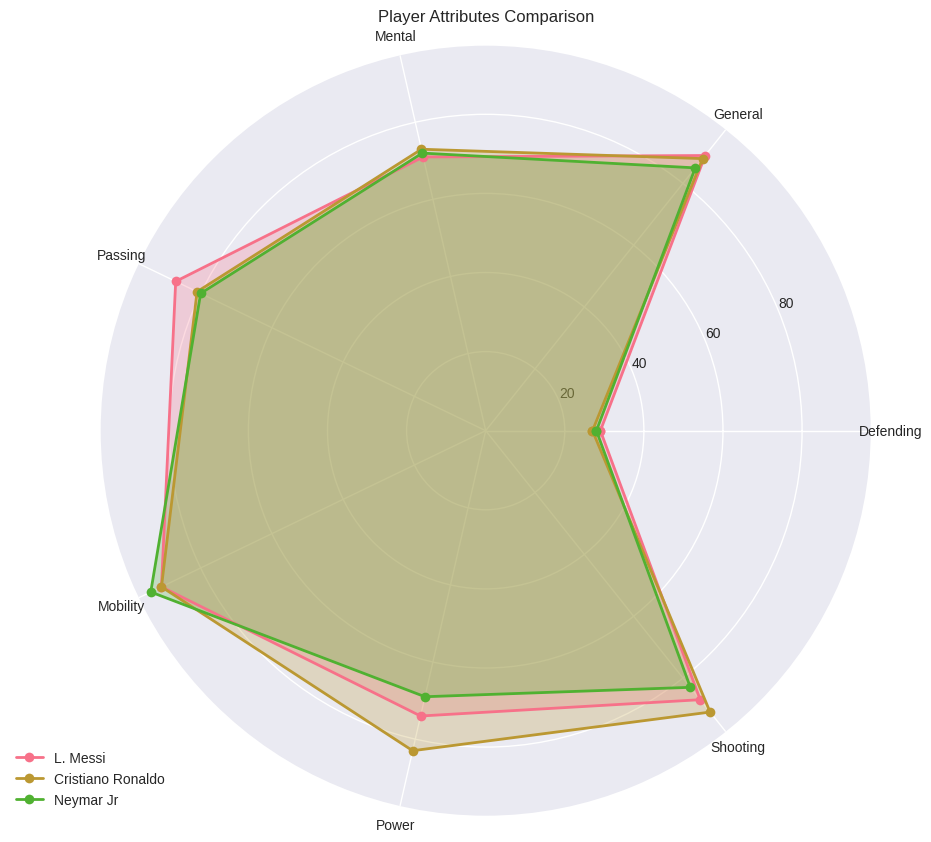

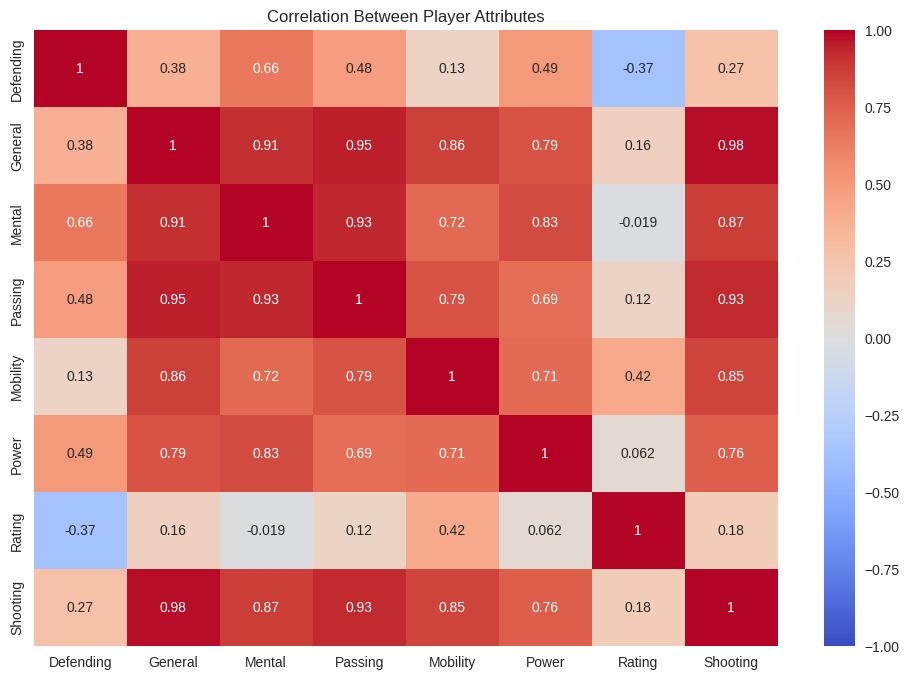

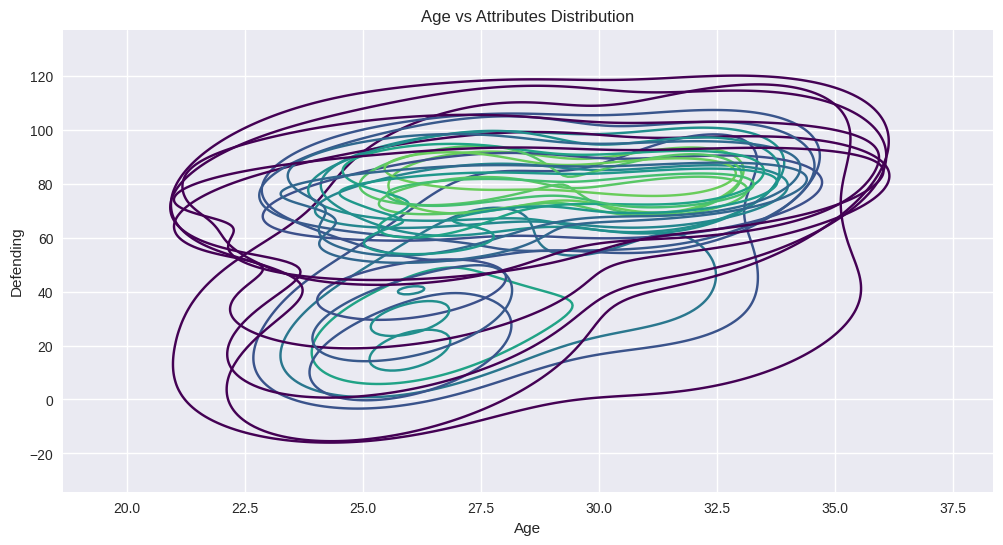

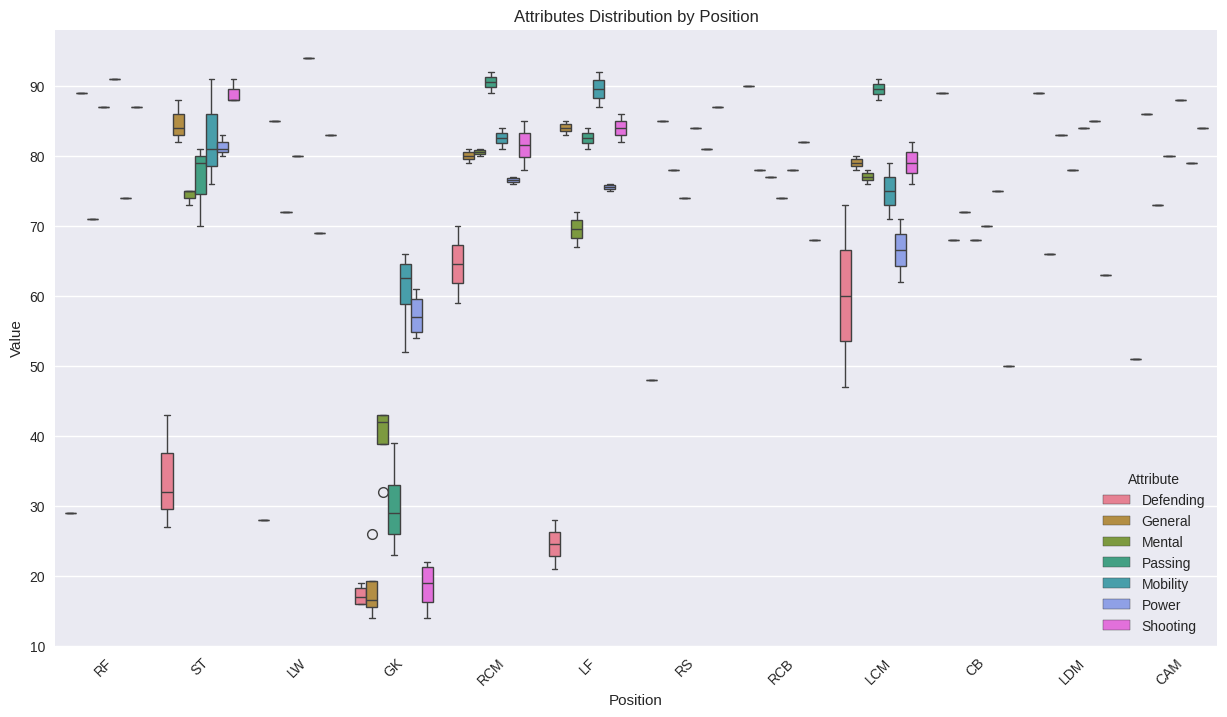

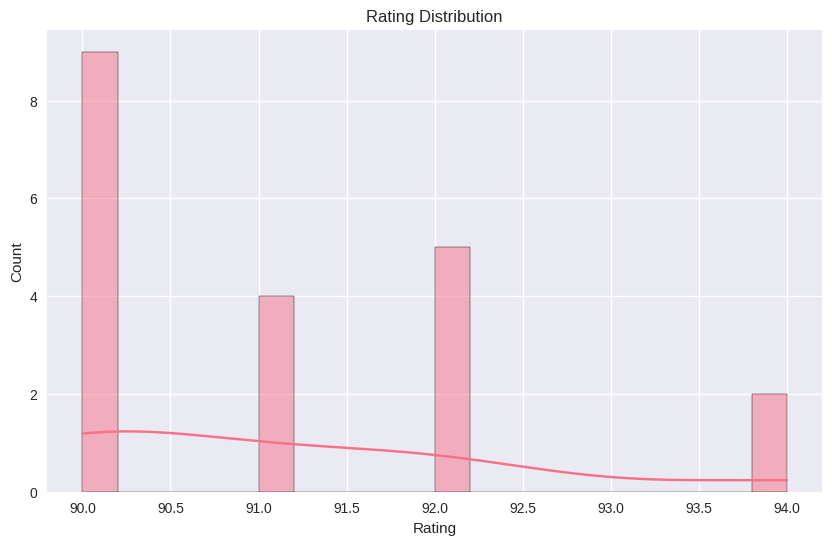

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('fifa_player_profiles.csv')

# Set the style
plt.style.use('seaborn')
sns.set_palette("husl")

# 1. Create Top Players Radar Chart
def create_radar_chart(player_names):
    # Prepare data
    categories = ['Defending', 'General', 'Mental', 'Passing', 'Mobility', 'Power', 'Shooting']
    players = df[df['Name'].isin(player_names)]

    # Set up the angles
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)

    # Close the plot by appending first value
    angles = np.concatenate((angles, [angles[0]]))

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    for idx, player in players.iterrows():
        values = [player[cat] for cat in categories]
        values = np.concatenate((values, [values[0]]))
        ax.plot(angles, values, 'o-', linewidth=2, label=player['Name'])
        ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title("Player Attributes Comparison")
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# 2. Create Correlation Heatmap
def create_correlation_heatmap():
    plt.figure(figsize=(12, 8))
    features = ['Defending', 'General', 'Mental', 'Passing', 'Mobility', 'Power', 'Rating', 'Shooting']
    corr = df[features].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Between Player Attributes')
    plt.show()

# 3. Create Age vs Attributes Distribution
def create_age_attributes():
    features = ['Defending', 'General', 'Mental', 'Passing', 'Mobility', 'Power']
    fig, ax = plt.subplots(figsize=(12, 6))

    for feature in features:
        sns.kdeplot(data=df, x='Age', y=feature, levels=5, cmap='viridis')

    plt.title('Age vs Attributes Distribution')
    plt.show()

# 4. Create Position-based Analysis
def create_position_analysis():
    plt.figure(figsize=(15, 8))
    features = ['Defending', 'General', 'Mental', 'Passing', 'Mobility', 'Power', 'Shooting']

    melted_df = df.melt(id_vars=['Position'],
                        value_vars=features,
                        var_name='Attribute',
                        value_name='Value')

    sns.boxplot(x='Position', y='Value', hue='Attribute', data=melted_df)
    plt.xticks(rotation=45)
    plt.title('Attributes Distribution by Position')
    plt.show()

# 5. Create Rating Distribution
def create_rating_distribution():
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='Rating', bins=20, kde=True)
    plt.title('Rating Distribution')
    plt.show()

# Execute all visualizations
print("Creating visualizations...")

# Radar chart for top 3 players
create_radar_chart(['L. Messi', 'Cristiano Ronaldo', 'Neymar Jr'])

# Correlation heatmap
create_correlation_heatmap()

# Age vs Attributes
create_age_attributes()

# Position Analysis
create_position_analysis()

# Rating Distribution
create_rating_distribution()